In [1]:
import os
import pandas
import geopandas
from matplotlib import pyplot as plt
from shapely.ops import unary_union
from pprint import pprint
import numpy as np

states_to_check = ['AK']
show_water = False

census_shapefile_tiger_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/shapefiles/'

code_lookup_dir = os.getcwd() + '/code_guide_lookups/'
extrasdir = '/home/idies/workspace/Storage/raddick/census/extras/'
cbsa_tract_dir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/cbsa_place_tract_reference/'
acs5_basedir = '/home/idies/workspace/Temporary/raddick/census_scratch/acs5/'

thisyear = 2019
best_epsg_proj = 5070

pandas.set_option('display.max_colwidth', None)

print('ok')

ok


In [73]:
print('reading CBSA shapefiles...')
cbsa_gdf = geopandas.read_file(census_shapefile_tiger_basedir+'{0:.0f}/CBSA/tl_{0:.0f}_us_cbsa.shp'.format(thisyear))
cbsa_gdf.loc[:, 'GEOID'] = pandas.to_numeric(cbsa_gdf['GEOID'], errors='coerce')
cbsa_gdf.loc[:, 'MEMI'] = pandas.to_numeric(cbsa_gdf['MEMI'], errors='coerce')
cbsa_gdf.loc[:, 'GEOID'] = cbsa_gdf.apply(lambda row: '{0:03d}00US{1:05d}'.format(320, row['GEOID']), axis=1)
cbsa_gdf = cbsa_gdf.set_index('GEOID')
cbsa_gdf = cbsa_gdf[[x for x in cbsa_gdf if x != 'geometry'] + ['geometry']]


geo_summary_levels_gdf = pandas.read_csv(extrasdir+'geo_summary_levels.csv', index_col='SUMLEVEL')

# os.listdir(census_shapefile_tiger_basedir+'2019/')

print('reading state shapefiles...')
state_gdf = geopandas.read_file(census_shapefile_tiger_basedir+'{0:.0f}/tl_{0:.0f}_us_state.shp'.format(thisyear))
state_gdf.loc[:, 'GEOID'] = state_gdf['GEOID'].apply(lambda x: '04000US'+x)
state_gdf = state_gdf.set_index('GEOID')

print('reading county shapefiles...')
county_gdf = geopandas.read_file(census_shapefile_tiger_basedir+'{0:.0f}/tl_{0:.0f}_us_county.shp'.format(thisyear))
county_gdf.loc[:, 'GEOID'] = county_gdf['GEOID'].apply(lambda x: '05000US'+x)
county_gdf = county_gdf.set_index('GEOID')
# # county_gdf.head(1).T

print('reading census tract shapefiles...')
tract_gdf = geopandas.GeoDataFrame()
for thisfile in [census_shapefile_tiger_basedir+'{0:.0f}/TRACT/'.format(thisyear)+x for x in os.listdir(census_shapefile_tiger_basedir+'{0:.0f}/TRACT/'.format(thisyear)) if (x[-4:] == '.shp')]:
    tract_gdf = pandas.concat((tract_gdf, geopandas.read_file(thisfile)))
tract_gdf.loc[:, 'GEOID'] = tract_gdf['GEOID'].apply(lambda x: '14000US'+x)
tract_gdf = tract_gdf.set_index('GEOID')

print('getting population for census tracts...')
pop_df = pandas.read_csv('{0:}{1:.0f}/estimates/estimates_acs2019_tract_for_cra_analysis_mac.csv'.format(acs5_basedir, thisyear))
pop_df = pop_df.rename(columns={'B01001_001': 'pop_total'})

tract_gdf = tract_gdf.join(pop_df[['pop_total']])
tract_gdf = tract_gdf[[x for x in tract_gdf.columns if x != 'geometry'] + ['geometry']]


print('reading place shapefiles...')
place_gdf = geopandas.GeoDataFrame()
for thisfile in sorted([census_shapefile_tiger_basedir+'{0:.0f}/PLACE/'.format(thisyear)+x for x in os.listdir(census_shapefile_tiger_basedir+'{0:.0f}/PLACE/'.format(thisyear)) if (x[-4:] == '.shp')]):
    place_gdf = pandas.concat((place_gdf, geopandas.read_file(thisfile)))
place_gdf.loc[:, 'GEOID'] = place_gdf['GEOID'].apply(lambda x: '16000US'+x)
place_gdf = place_gdf.set_index('GEOID')




print('converting should-be-numeric values to numeric...')            
for thisgdf in [state_gdf, county_gdf, tract_gdf, place_gdf]:
    thisgdf.loc[:, 'STATEFP'] = pandas.to_numeric(thisgdf['STATEFP'], errors='coerce')

for thisgdf in [cbsa_gdf, state_gdf, county_gdf, tract_gdf, place_gdf]:
    thisgdf.loc[:, 'INTPTLON'] = pandas.to_numeric(thisgdf['INTPTLON'], errors='coerce')
    thisgdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(thisgdf['INTPTLAT'], errors='coerce')

if (show_water):
    print('reading water shapefiles...')
    water_gdf = geopandas.GeoDataFrame()
    state_abbreviations_df = pandas.read_csv(extrasdir+'statecodes.csv', index_col='STUSAB')
    for this_state_num in state_abbreviations_df[state_abbreviations_df.index.isin(states_to_check)]['STATE'].tolist():
        water_shapefile_name_list = ['{0:}{1:.0f}/AREAWATER/'.format(census_shapefile_tiger_basedir, thisyear)+x for x in os.listdir('{0:}{1:.0f}/AREAWATER'.format(census_shapefile_tiger_basedir, thisyear)) if ('tl_{0:04d}_{1:02d}'.format(thisyear, this_state_num) in x) and (x[-4:] == '.shp')]
        for i in range(0,len(water_shapefile_name_list)):
            if (np.mod(i,10) == 0):
                print('Parsing water area {0:,.0f} of {1:,.0f}...'.format(i, len(water_shapefile_name_list)))
            water_gdf = pandas.concat((water_gdf, geopandas.read_file(water_shapefile_name_list[i])))
    water_gdf.loc[:, 'INTPTLON'] = pandas.to_numeric(water_gdf['INTPTLON'], errors='coerce')
    water_gdf.loc[:, 'INTPTLAT'] = pandas.to_numeric(water_gdf['INTPTLAT'], errors='coerce')

print('backing up...')
county_gdf_bk = county_gdf
tract_gdf_bk = tract_gdf
place_gdf_bk = place_gdf
cbsa_gdf_bk = cbsa_gdf
place_gdf_bk = place_gdf
#pop_df_bk = pop_df
print('Done!')
tract_gdf[['STATEFP','COUNTYFP','TRACTCE','pop_total']].sample(10)

reading CBSA shapefiles...
reading state shapefiles...
reading county shapefiles...
reading census tract shapefiles...
getting population for census tracts...
reading place shapefiles...
converting should-be-numeric values to numeric...
backing up...
Done!


,STATEFP,COUNTYFP,TRACTCE,pop_total
GEOID,,,,
14000US27123980000,27,123,980000,NaN
14000US39049007010,39,049,007010,NaN
14000US39081000800,39,081,000800,NaN
14000US48201330500,48,201,330500,NaN
14000US32003003244,32,003,003244,NaN
14000US36061017200,36,061,017200,NaN
14000US01041963900,1,041,963900,NaN
14000US36047027400,36,047,027400,NaN
14000US48181000303,48,181,000303,NaN


# Match places and CBSAs

In [67]:
place_gdf = place_gdf_bk

nplaces = len(place_gdf[place_gdf['STATEFP'].isin([2])])
ncbsas = len(cbsa_gdf)
pct_area_overlap_tolerance = 0.001

i = 0

print('Matching each place to its cbsa...')
place_gdf = place_gdf.assign(CBSA = np.nan)
place_gdf = place_gdf.assign(CBSA_intersection_percentage = np.nan)

for ix, thisrow in place_gdf[place_gdf['STATEFP'].isin([2])].iterrows():
    #print(thisrow['NAME'])
    if (np.mod(i,100) == 0):
        print('Processing place {0:,.0f} of {1:,.0f}...'.format(i, nplaces))
    matching_cbsa = []
    for jx, thatrow in cbsa_gdf.iterrows():
        if (thisrow.geometry.intersects(thatrow.geometry)):
            matching_cbsa.append(jx)
    if (len(matching_cbsa) > 1):
        print('{0:} has intersected the {1:.0f} CBSAs...'.format(thisrow['NAMELSAD'], len(matching_cbsa)))
        for this_matcher in matching_cbsa:
            print('\t{0:}...'.format(cbsa_gdf.loc[this_matcher]['NAMELSAD']))
        print('\n')
    elif (len(matching_cbsa) == 1):
        if (thisrow.geometry.intersection(cbsa_gdf.loc[matching_cbsa[0]].geometry).area / thisrow.geometry.area > pct_area_overlap_tolerance):
            place_gdf.loc[ix, 'CBSA'] = matching_cbsa[0]
            place_gdf.loc[ix, 'CBSA_intersection_percentage'] = thisrow.geometry.intersection(cbsa_gdf.loc[matching_cbsa[0]].geometry).area / thisrow.geometry.area        
    i += 1

print('Done!')

Matching each place to its cbsa...
Processing place 0 of 354...
Processing place 100 of 354...
Processing place 200 of 354...
Processing place 300 of 354...
Done!


# Match counties and tracts to CBSAs

In [68]:
county_gdf = county_gdf_bk
tract_gdf = tract_gdf_bk

ncounties = len(county_gdf[county_gdf['STATEFP'].isin([2])])
ntracts = len(tract_gdf[tract_gdf['STATEFP'].isin([2])])
ncbsas = len(cbsa_gdf)
area_overlap_tolerance = 0.001

i = 0

print('Matching each county to its CBSA...')
county_gdf = county_gdf.assign(CBSA = np.nan)
county_gdf = county_gdf.assign(CBSA_intersection_percentage = np.nan)

for ix, thisrow in county_gdf[county_gdf['STATEFP'].isin([2])].iterrows():
    #print(thisrow['NAME'])
    if (np.mod(i,100) == 0):
        print('Processing tract {0:,.0f} of {1:,.0f}...'.format(i, ntracts))
    matching_cbsa = []
    for jx, thatrow in cbsa_gdf.iterrows():
        if (thisrow.geometry.intersects(thatrow.geometry)):
            matching_cbsa.append(jx)
    if (len(matching_cbsa) > 1):
        print('{0:} has intersected {1:.0f} CBSAs...'.format(thisrow['COUNTYFP']+' '+thisrow['NAMELSAD'], len(matching_cbsa)))
        for this_matcher in matching_cbsa:
            print('\t{0:}...'.format(cbsa_gdf.loc[this_matcher]['NAMELSAD']))
        print('\n')
    elif (len(matching_cbsa) == 1):
        if (thisrow.geometry.intersection(cbsa_gdf.loc[matching_cbsa[0]].geometry).area / thisrow.geometry.area > area_overlap_tolerance):
            county_gdf.loc[ix, 'CBSA'] = matching_cbsa[0]
            county_gdf.loc[ix, 'CBSA_intersection_percentage'] = thisrow.geometry.intersection(cbsa_gdf.loc[matching_cbsa[0]].geometry).area / thisrow.geometry.area        
    i += 1

print('Matching each tract to its CBSA...')
tract_gdf = tract_gdf.assign(CBSA = np.nan)
tract_gdf = tract_gdf.assign(CBSA_intersection_percentage = np.nan)

for ix, thisrow in tract_gdf[tract_gdf['STATEFP'].isin([2])].iterrows():
    #print(thisrow['NAME'])
    if (np.mod(i,100) == 0):
        print('Processing tract {0:,.0f} of {1:,.0f}...'.format(i, ntracts))
    matching_cbsa = []
    for jx, thatrow in cbsa_gdf.iterrows():
        if (thisrow.geometry.intersects(thatrow.geometry)):
            matching_cbsa.append(jx)
    if (len(matching_cbsa) > 1):
        print('{0:} has intersected {1:.0f} CBSAs...'.format(thisrow['COUNTYFP']+' '+thisrow['NAMELSAD'], len(matching_cbsa)))
        for this_matcher in matching_cbsa:
            print('\t{0:}...'.format(cbsa_gdf.loc[this_matcher]['NAMELSAD']))
        print('\n')
    elif (len(matching_cbsa) == 1):
        if (thisrow.geometry.intersection(cbsa_gdf.loc[matching_cbsa[0]].geometry).area / thisrow.geometry.area > area_overlap_tolerance):
            tract_gdf.loc[ix, 'CBSA'] = matching_cbsa[0]
            tract_gdf.loc[ix, 'CBSA_intersection_percentage'] = thisrow.geometry.intersection(cbsa_gdf.loc[matching_cbsa[0]].geometry).area / thisrow.geometry.area        
    i += 1

print('Done!')
#tract_gdf['CBSA'].dropna()



Matching each county to its CBSA...
Processing tract 0 of 167...
290 Yukon-Koyukuk Census Area has intersected 2 CBSAs...
	Fairbanks, AK Metro Area...
	Anchorage, AK Metro Area...


068 Denali Borough has intersected 2 CBSAs...
	Fairbanks, AK Metro Area...
	Anchorage, AK Metro Area...


240 Southeast Fairbanks Census Area has intersected 2 CBSAs...
	Fairbanks, AK Metro Area...
	Anchorage, AK Metro Area...


Matching each tract to its CBSA...
068 Census Tract 1 has intersected 2 CBSAs...
	Fairbanks, AK Metro Area...
	Anchorage, AK Metro Area...


Processing tract 100 of 167...
240 Census Tract 4 has intersected 2 CBSAs...
	Fairbanks, AK Metro Area...
	Anchorage, AK Metro Area...


Done!


In [70]:
cbsa_gdf = cbsa_gdf_bk
#cbsa_gdf = cbsa_gdf.assign(pop_total = np.nan)
tract_gdf['pop_total'].sum()

0.0

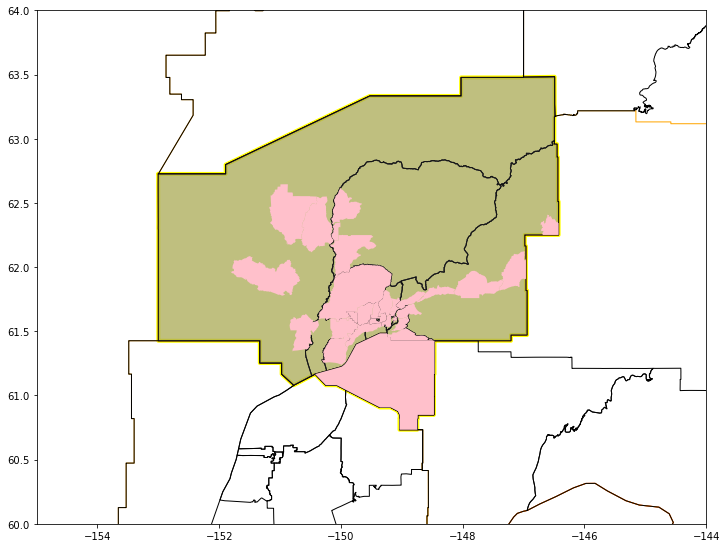

In [49]:
#use_projection = False
states_to_check = ['AK']
fig, ax = plt.subplots(1,1, figsize=(12,12))
# #cbsa_gdf[cbsa_gdf['NAME'].apply(lambda x: (('Philadelphia' in x) & ('PA' in x)))].plot(ax=ax)

# xlimits = (focus_area_geo.bounds[0], focus_area_geo.bounds[2])
# ylimits = (focus_area_geo.bounds[1], focus_area_geo.bounds[3])
xlimits = (-155,-144)
ylimits = (60,64)

focus_area_geo = unary_union(state_gdf[state_gdf['STUSPS'].isin(states_to_check)].geometry.tolist())

cbsa_gdf[cbsa_gdf.geometry.apply(lambda x: x.intersects(focus_area_geo))].plot(ax=ax, color='none', edgecolor='yellow', lw=4)

if (show_water):
    print('plotting water areas...')
    water_gdf.plot(ax=ax)


# for ix, thisrow in cbsa_gdf[((cbsa_gdf['INTPTLON'] >= xlimits[0]) & (cbsa_gdf['INTPTLON'] <= xlimits[1])) & ((cbsa_gdf['INTPTLAT'] >= ylimits[0]) & (cbsa_gdf['INTPTLAT'] <= ylimits[1]))].iterrows():
#     this_cbsa = ix
#     if (thisrow['MEMI'] == 1):
#         annotator = thisrow['NAME'][:-4] + 'MSA'
#     else:
#         annotator = thisrow['NAME'][:-4] + 'µSA'
#     ax.annotate(
#         annotator, 
#         (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#         color='black', backgroundcolor='white', ha='center', va='center'
#     )

state_gdf[state_gdf['STUSPS'].isin(states_to_check)].plot(ax=ax, color='none', edgecolor='red')


county_gdf[
    ((county_gdf['INTPTLON'] >= xlimits[0]) & (county_gdf['INTPTLON'] <= xlimits[1])) & ((county_gdf['INTPTLAT'] >= ylimits[0]) & (county_gdf['INTPTLAT'] <= ylimits[1]))
].plot(ax=ax, color='none', edgecolor='orange')
county_gdf[(county_gdf['CBSA'] == '32000US11260') & 
    ((county_gdf['INTPTLON'] >= xlimits[0]) & (county_gdf['INTPTLON'] <= xlimits[1])) & ((county_gdf['INTPTLAT'] >= ylimits[0]) & (county_gdf['INTPTLAT'] <= ylimits[1]))
].plot(ax=ax, color='yellow', edgecolor='orange', alpha=0.5)
# for ix, thisrow in county_gdf[(county_gdf['CBSA'] == '32000US11260') & 
#     ((county_gdf['INTPTLON'] >= xlimits[0]) & (county_gdf['INTPTLON'] <= xlimits[1])) & ((county_gdf['INTPTLAT'] >= ylimits[0]) & (county_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     annotator = '{0:} ({1:.1%})'.format(thisrow['NAME'], thisrow['CBSA_intersection_percentage'])
#     ax.annotate(
#         annotator, 
#         (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#         color='orange', backgroundcolor='white', ha='center', va='center'
#     )

tract_gdf[
    ((tract_gdf['INTPTLON'] >= xlimits[0]) & (tract_gdf['INTPTLON'] <= xlimits[1])) & ((tract_gdf['INTPTLAT'] >= ylimits[0]) & (tract_gdf['INTPTLAT'] <= ylimits[1]))
].plot(ax=ax, color='none', edgecolor='black')
tract_gdf[(tract_gdf['CBSA'] == '32000US11260') & 
    ((tract_gdf['INTPTLON'] >= xlimits[0]) & (tract_gdf['INTPTLON'] <= xlimits[1])) & ((tract_gdf['INTPTLAT'] >= ylimits[0]) & (tract_gdf['INTPTLAT'] <= ylimits[1]))
].plot(ax=ax, color='gray', edgecolor='black', alpha=0.5)
# for ix, thisrow in tract_gdf[(tract_gdf['CBSA'] == '32000US11260') & 
#     ((tract_gdf['INTPTLON'] >= xlimits[0]) & (tract_gdf['INTPTLON'] <= xlimits[1])) & ((tract_gdf['INTPTLAT'] >= ylimits[0]) & (tract_gdf['INTPTLAT'] <= ylimits[1]))
# ].iterrows():
#     annotator = '{0:} ({1:.1%})'.format(thisrow['NAME'], thisrow['CBSA_intersection_percentage'])
#     ax.annotate(
#         annotator, 
#         (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#         color='black', backgroundcolor='white', ha='center', va='center'
#     )


place_gdf[place_gdf['CBSA'] == '32000US11260'].plot(ax=ax, color='pink')

# for ix, thisrow in place_gdf[(place_gdf['CBSA'] == '32000US11260') & (place_gdf['CBSA_intersection_percentage'] <= 0.999)].iterrows():
#     annotator = '{0:} ({1:.5%})'.format(thisrow['NAME'], thisrow['CBSA_intersection_percentage'])
#     plt.annotate(annotator, (thisrow['INTPTLON'], thisrow['INTPTLAT']), (thisrow['INTPTLON'], thisrow['INTPTLAT']), 
#                 color='red', backgroundcolor='white', ha='center', va='center')


plt.xlim(xlimits)
plt.ylim(ylimits)

plt.show()
#cbsa_gdf.columns
#place_gdf['CBSA'].drop_duplicates()


In [ ]:
# tract_guide_df = pandas.DataFrame()
# for thisfile in [x for x in os.listdir(cbsa_tract_dir) if '.xls' in x]:
#     tract_guide_df = pandas.concat((tract_guide_df, pandas.read_excel(cbsa_tract_dir+thisfile, header=2)))
# #tract_guide_df = 
# tract_guide_df.loc[:, 'CBSA Code'] = pandas.to_numeric(tract_guide_df['CBSA Code'], errors='coerce')
# tract_guide_df = tract_guide_df[tract_guide_df['CBSA Code'].notnull()]
# tract_guide_df
cbsa_gdf[['CSAFP','CBSAFP','NAME','NAMELSAD','LSAD', 'MEMI', 'MTFCC']]

In [ ]:

place_gdf
